In [1]:
import numpy as np # Successfully installed numpy-1.23.5
import pandas as pd # Successfully installed pandas-1.3.5
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split, Subset
import torch
import sys
import time
import hydra
from omegaconf import DictConfig, OmegaConf
import wandb
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath(".."))
from models.models import GATWithJK
from preprocessing import graph_creation
from training_utils import PyTorchTrainer, PyTorchDistillationTrainer, DistillationTrainer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
teacher_model = GATWithJK(in_channels=10, hidden_channels=32, out_channels=1, num_layers=5, heads=8).to(device)
student_model = GATWithJK(in_channels=10, hidden_channels=32, out_channels=1, num_layers=2, heads=4).to(device)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (outputs > 0.5).float()  # Assuming binary classification
            all_preds.append(preds.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Flatten the lists
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return accuracy, precision, recall, f1

In [19]:
# List of test datasets and corresponding model weights
test_datasets = [
    # {"folder": "../datasets/can-train-and-test-v1.5/set_01", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_01.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_01.pth"},

    # {"folder": "../datasets/can-train-and-test-v1.5/set_02", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_02.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_02.pth"},

    # {"folder": "../datasets/can-train-and-test-v1.5/set_03", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_03.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_03.pth"},

    # {"folder": "../datasets/can-train-and-test-v1.5/set_04", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_04.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_04.pth"},

    {"folder": "../datasets/can-train-and-test-v1.5/hcrl-ch", 
     "teacher_weight": "../saved_models/best_teacher_model_ch.pth", 
     "student_weight": "../saved_models/final_student_model_ch.pth"},
     
    # {"folder": "../datasets/can-train-and-test-v1.5/hcrl-sa", 
    #  "teacher_weight": "../saved_models/best_teacher_model_hcrl_sa.pth", 
    #  "student_weight": "../saved_models/final_student_model_hcrl_sa.pth"},
]

# Iterate through each dataset
for dataset_info in test_datasets:
    root_folder = dataset_info["folder"]
    teacher_weight = dataset_info["teacher_weight"]
    student_weight = dataset_info["student_weight"]

    print(f"Evaluating dataset in root folder: {root_folder}")

    # Load the test dataset using graph_creation
    test_dataset = graph_creation(root_folder, folder_type="test_")
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Load the teacher model
    teacher_model.load_state_dict(torch.load(teacher_weight))
    teacher_model.eval()

    # Load the student model
    student_model.load_state_dict(torch.load(student_weight))
    student_model.eval()

    # Evaluate the teacher model
    teacher_metrics = evaluate_model(teacher_model, test_loader, device)
    print(f"Teacher Model - Accuracy: {teacher_metrics[0]:.4f}, Precision: {teacher_metrics[1]:.4f}, Recall: {teacher_metrics[2]:.4f}, F1 Score: {teacher_metrics[3]:.4f}")

    # Evaluate the student model
    student_metrics = evaluate_model(student_model, test_loader, device)
    print(f"Student Model - Accuracy: {student_metrics[0]:.4f}, Precision: {student_metrics[1]:.4f}, Recall: {student_metrics[2]:.4f}, F1 Score: {student_metrics[3]:.4f}")

    print("-" * 50)

Evaluating dataset in root folder: ../datasets/can-train-and-test-v1.5/hcrl-ch
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_01_DoS\DoS-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_02_fuzzing\fuzzing-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_03_gear_spoofing\gear-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_04_rpm_spoofing\rpm-test.csv
Teacher Model - Accuracy: 0.9977, Precision: 0.9969, Recall: 0.9985, F1 Score: 0.9977
Student Model - Accuracy: 0.9997, Precision: 1.0000, Recall: 0.9993, F1 Score: 0.9997
--------------------------------------------------


In [4]:
# Load the test dataset using graph_creation
test_dataset = graph_creation("../datasets/can-train-and-test-v1.5/hcrl-ch", folder_type="test_")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_01_DoS\DoS-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_02_fuzzing\fuzzing-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_03_gear_spoofing\gear-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_04_rpm_spoofing\rpm-test.csv


In [23]:
teacher_model.eval()
embeddings_list = []
with torch.no_grad():
    for data in test_loader:  # Iterate through the DataLoader
        data = data.to(device)  # Move the batch to the device
        embedding = teacher_model(data)  # Get the embeddings
        embeddings_list.append(embedding.cpu())  # Collect embeddings on the CPU

# Combine all embeddings into a single tensor
embeddings = torch.cat(embeddings_list, dim=0)  # Shape: [num_nodes, embedding_dim]

In [ ]:
teacher_model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        graph_embedding = teacher_model(data, return_intermediate=False)
        #print(f"Graph embedding shape: {graph_embedding.shape}")

Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Siz

KeyboardInterrupt: 

In [ ]:
teacher_model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)
        for i, layer_output in enumerate(intermediate_outputs):
            # print(f"Layer {i} output shape: {layer_output.shape}")

Layer 0 output shape: torch.Size([2409, 256])
Layer 1 output shape: torch.Size([2409, 256])
Layer 2 output shape: torch.Size([2409, 256])
Layer 3 output shape: torch.Size([2409, 256])
Layer 4 output shape: torch.Size([2409, 256])
Layer 0 output shape: torch.Size([2581, 256])
Layer 1 output shape: torch.Size([2581, 256])
Layer 2 output shape: torch.Size([2581, 256])
Layer 3 output shape: torch.Size([2581, 256])
Layer 4 output shape: torch.Size([2581, 256])
Layer 0 output shape: torch.Size([2438, 256])
Layer 1 output shape: torch.Size([2438, 256])
Layer 2 output shape: torch.Size([2438, 256])
Layer 3 output shape: torch.Size([2438, 256])
Layer 4 output shape: torch.Size([2438, 256])
Layer 0 output shape: torch.Size([2484, 256])
Layer 1 output shape: torch.Size([2484, 256])
Layer 2 output shape: torch.Size([2484, 256])
Layer 3 output shape: torch.Size([2484, 256])
Layer 4 output shape: torch.Size([2484, 256])
Layer 0 output shape: torch.Size([2667, 256])
Layer 1 output shape: torch.Size([

Embeddings shape: torch.Size([2409, 256])
Labels shape: (2409,)


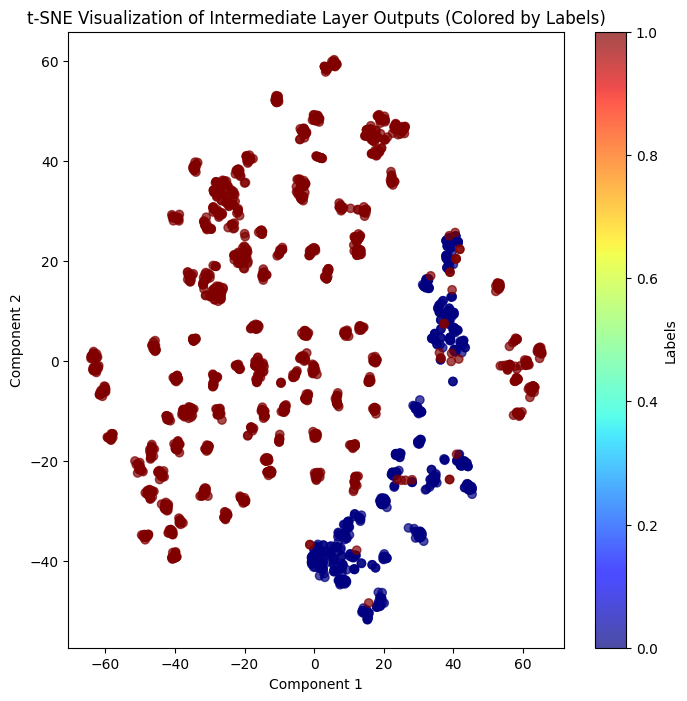

In [11]:
# Extract intermediate outputs
# Extract intermediate outputs and labels
teacher_model.eval()
intermediate_outputs_list = []
labels_list = []

max_batches = 1  # Limit the number of batches to process

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= max_batches:  # Stop after processing `max_batches`
            break
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)  # Get intermediate outputs
        intermediate_outputs_list.append(intermediate_outputs[-1].cpu())  # Use the last layer's output
        labels_list.append(data.y[data.batch].cpu())  # Map graph labels to nodes using `data.batch`

# Combine outputs and labels into single tensors
embeddings = torch.cat(intermediate_outputs_list, dim=0)  # Shape: [num_nodes, embedding_dim]
labels = torch.cat(labels_list, dim=0).numpy()  # Shape: [num_nodes]
print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")
# Apply t-SNE
z = TSNE(n_components=2).fit_transform(embeddings.numpy())  # Reduce to 2D

# Plot with labels
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.title("t-SNE Visualization of Intermediate Layer Outputs (Colored by Labels)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")
plt.show()

c:\Users\rober\miniconda3\envs\graph\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rober\miniconda3\envs\graph\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


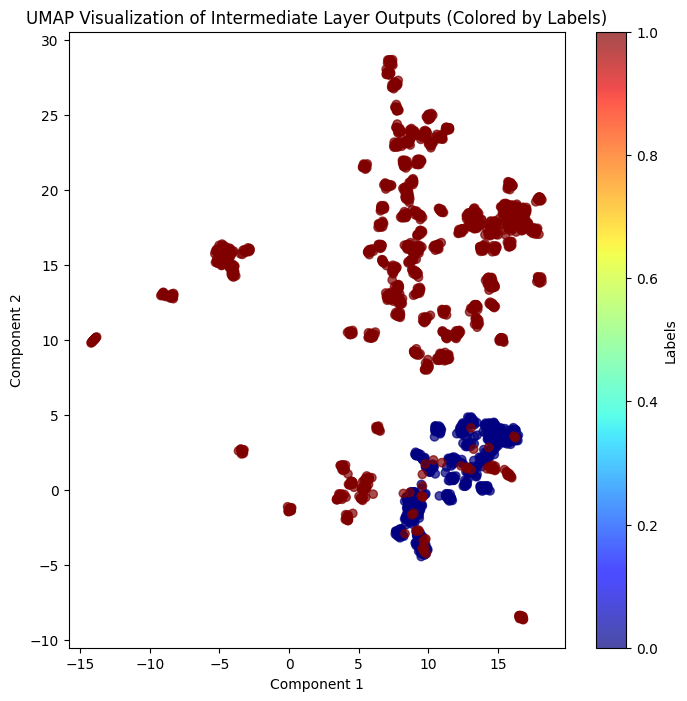

In [13]:
import umap
# Extract intermediate outputs and labels
teacher_model.eval()
intermediate_outputs_list = []
labels_list = []

max_batches = 1  # Limit the number of batches to process

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= max_batches:  # Stop after processing `max_batches`
            break
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)  # Get intermediate outputs
        intermediate_outputs_list.append(intermediate_outputs[-1].cpu())  # Use the last layer's output

        # Expand graph-level labels to match the number of nodes
        labels_list.append(data.y[data.batch].cpu())  # Map graph labels to nodes using `data.batch`

# Combine outputs and labels into single tensors
embeddings = torch.cat(intermediate_outputs_list, dim=0)  # Shape: [num_nodes, embedding_dim]
labels = torch.cat(labels_list, dim=0).numpy()  # Shape: [num_nodes]

# Apply UMAP
# reducer = umap.UMAP(n_components=2, random_state=42) # default settings

# reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=42) # local structure
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42) # global structure
z = reducer.fit_transform(embeddings.numpy())  # Reduce to 2D

# Plot with labels
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.title("UMAP Visualization of Intermediate Layer Outputs (Colored by Labels)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")
plt.show()

c:\Users\rober\miniconda3\envs\graph\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rober\miniconda3\envs\graph\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\rober\miniconda3\envs\graph\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


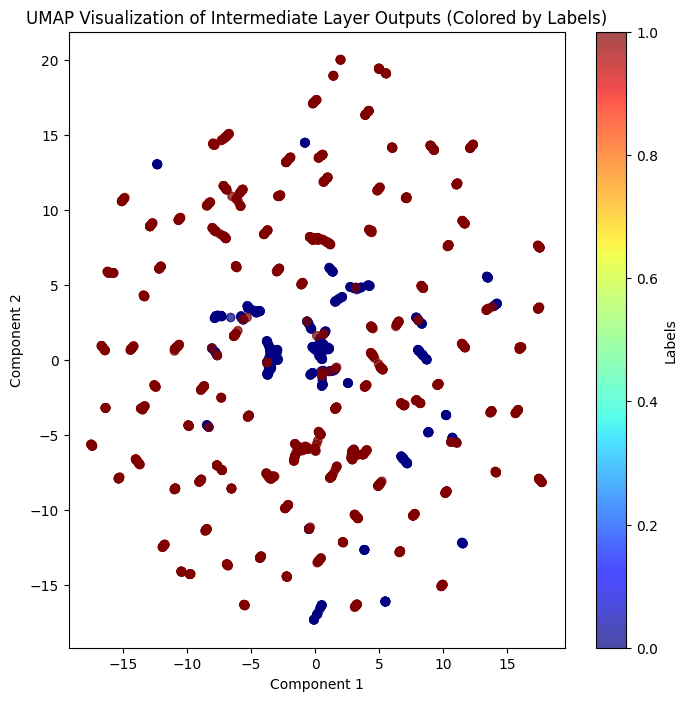

In [14]:
import umap
# Extract intermediate outputs and labels
teacher_model.eval()
intermediate_outputs_list = []
labels_list = []

max_batches = 1  # Limit the number of batches to process

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= max_batches:  # Stop after processing `max_batches`
            break
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)  # Get intermediate outputs
        intermediate_outputs_list.append(intermediate_outputs[-1].cpu())  # Use the last layer's output

        # Expand graph-level labels to match the number of nodes
        labels_list.append(data.y[data.batch].cpu())  # Map graph labels to nodes using `data.batch`

# Combine outputs and labels into single tensors
embeddings = torch.cat(intermediate_outputs_list, dim=0)  # Shape: [num_nodes, embedding_dim]
labels = torch.cat(labels_list, dim=0).numpy()  # Shape: [num_nodes]

# Apply UMAP
# reducer = umap.UMAP(n_components=2, random_state=42) # default settings

reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=42) # local structure
# reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42) # global structure
z = reducer.fit_transform(embeddings.numpy())  # Reduce to 2D

# Plot with labels
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.title("UMAP Visualization of Intermediate Layer Outputs (Colored by Labels)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")
plt.show()